In [2]:
from mech_module import *
from arima_functions import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Long term power prediction at a location

This notebook will combine the ARIMA time series forecasting at a location and the main power calculation. The output will be average daily power generation at a location for a year. This time series will be used to calculate minimum, maximum and average power as well as the total power.

1. Import data, fit ARIMA model and forecast power generation at a location

In [20]:
import requests
import pandas as pd

# script for returning elevation from lat, long, based on open elevation data
# which in turn is based on SRTM
def get_elevation(lat, long):
    query = ('https://api.open-elevation.com/api/v1/lookup'
             f'?locations={lat},{long}')
    r = requests.get(query).json()  # json object, various ways you can extract value
    # one approach is to use pandas json functionality:
    elevation = pd.json_normalize(r, 'results')['elevation'].values[0]
    return elevation

# points from google maps
upstream = get_elevation(25.203444,89.686458)
downstream = get_elevation(25.172212, 89.662100) 
slope = (downstream - upstream)/1000 # 1140 is the distance between the two points in meters
print(slope)

0.003


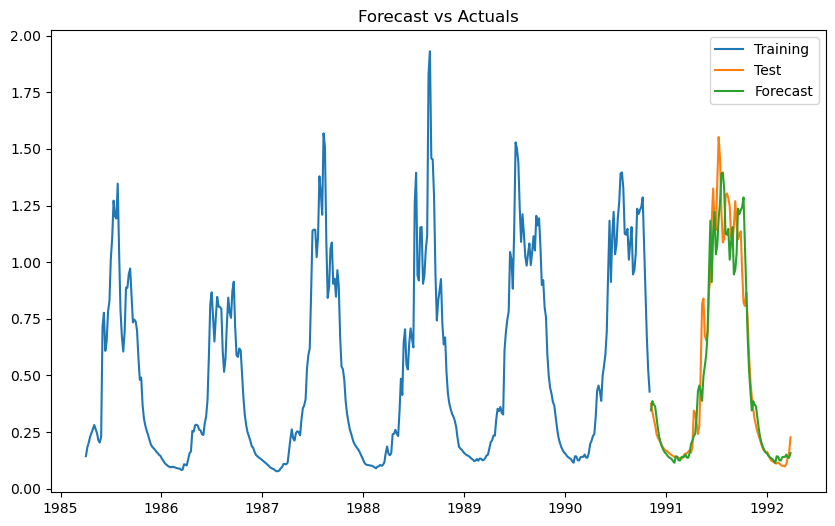

In [22]:
# using data from the Brahamaputra River, Bangladesh
file_path = "DATA/2651100_Q_Day.Cmd.txt"
metadata, data = read_data(file_path)
station_info, parsed_data = process_data(metadata, data)
Q = parsed_data['Value'].mean() # average discharge m^3/s
W = 9000 # width in meters
S = slope # slope at location
D = (Q / (W**1.02 * S**0.35))**(1/1.74) # depth in meters
parsed_data['Velocity'] = parsed_data['Value'] / (W * D) # velocity in m/s
parsed_data = downsample(parsed_data)
train, test = split_data(parsed_data, split=0.8)
model = arima_model(train, order=(2,0,2), seasonal_order=(0,1,0,73))
forecast_data = forecast(model, test)
plt.figure(figsize=(10,6))
plt.plot(train.dropna(),  label='Training')
plt.plot(test.dropna(), label='Test')
plt.plot(forecast_data, label='Forecast')
plt.title('Forecast vs Actuals')
plt.legend()
plt.show()

2. Calculate daily power generation at a location.

Need to upsample the time series to daily frequency and calculate average power generation at a location for a year.

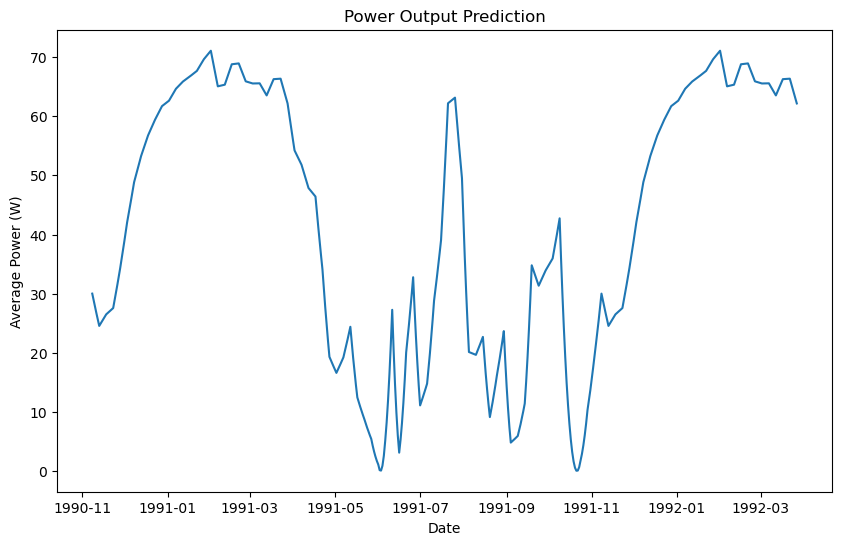

In [25]:
# upsample forecast data
full_forecast_data = forecast_data.resample('D').mean()
full_forecast_data = full_forecast_data.interpolate(method='linear')
### calculate daily power output
# turbine parameters
turbine_width = 1.2
turbine_diameter = 1.2
r_drum = 0.425
pontoon_grid_multiplier = 1.15 # found in main.ipynb
generator_eff = 0.9
gearbox_eff = 0.95
efficiency = generator_eff * gearbox_eff

# calculate power output
shaft_power = power(full_forecast_data * pontoon_grid_multiplier, runner_diameter=turbine_diameter, r_drum=r_drum, L=turbine_width/2, RPM=20) * efficiency

# plot power output
plt.figure(figsize=(10,6))
plt.plot(shaft_power)
plt.title('Power Output Prediction')
plt.xlabel('Date')
plt.ylabel('Average Power (W)')
plt.show()


In [26]:
# calculate the daily, monthly, and yearly energy output
daily_energy = shaft_power.resample('D').sum() / 1000
monthly_energy = shaft_power.resample('M').sum() / 1000
yearly_energy = shaft_power.resample('Y').sum() / 1000
print(f"Daily Energy Output (kWh): {daily_energy.mean()}")
print(f"Monthly Energy Output (kWh): {monthly_energy.mean()}")
print(f"Yearly Energy Output (kWh): {yearly_energy.mean()}")


Daily Energy Output (kWh): 0.04265407330744119
Monthly Energy Output (kWh): 1.2695859466803083
Yearly Energy Output (kWh): 7.194320364521747
